# PART - B: Transformer Based Image Captioning Model using ViT
This notebook implements an image captioning model using a Vision Transformer (ViT) encoder and a BERT-based decoder. 

The code below is majorly divided into 6 sections:
- Import and Setup
- Dataset Preprocessing
- Model Creation
- Model Training
- Evalution
- Final Output

## Import and Setup
In this section, we import libraries and set up configurations for the image captioning model. We import datasets for data handling, transformers for models, pandas for data manipulation, and torch for GPU availability and device selection. 
- We define macros for batch sizes, learning rate, epochs, and maximum lengths. 
- We check for GPU availability and set the device accordingly. 
- We define file paths for the dataset and preprocess captions in the DataFrames. 
- Finally, we initialize a BERT tokenizer and a ViT image processor for tokenizing captions and processing images.

In [1]:
import datasets
import transformers
import pandas as pd
import torch
from torch.utils.data.dataset import Dataset
from pathlib import Path

#Tokenizer from scratch on vocabulary of corpus
from tokenizers import ByteLevelBPETokenizer

# Decoder
# RobertaLM for learning
# After training tokenizern we will wrap it so it can be used by Roberta model
from transformers import RobertaConfig
from transformers import RobertaForMaskedLM
from transformers import RobertaTokenizerFast

#Encoder-Decoder Model
from transformers import VisionEncoderDecoderModel

#Training
# When using previous version of the library you need the following two lines
from transformers import Seq2SeqTrainer
from transformers import Seq2SeqTrainingArguments
from transformers import Trainer, TrainingArguments

2024-04-17 10:50:28.690353: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-17 10:50:28.690486: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-17 10:50:28.821726: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [3]:
TRAIN_BATCH_SIZE = 20   # input batch size for training (default: 64)
VALID_BATCH_SIZE = 5   # input batch size for testing (default: 1000)
VAL_EPOCHS = 1 
LEARNING_RATE = 1e-4    # learning rate (default: 0.01)
SEED = 42               # random seed (default: 42)
MAX_LEN = 128           # Max length for product description
SUMMARY_LEN = 20         # Max length for product names

TRAIN_EPOCHS = 10       # number of epochs to train (default: 10)
WEIGHT_DECAY = 0.01
SEED = 42               # random seed (default: 42)
MAX_LEN = 128
SUMMARY_LEN = 40   # Maximum length of caption generated by the model

### Note:
We are importing the dataset from path '/kaggle/input/custom-captions/custom_captions_dataset'.

You may have to change this path according the path at which the dataset is present.

In [4]:
import pandas as pd

# Define paths relative to the dataset location in Kaggle
dataset_folder = '/kaggle/input/custom-captions/custom_captions_dataset'
train_csv_file = f'{dataset_folder}/train.csv'
test_csv_file = f'{dataset_folder}/test.csv'
val_csv_file = f'{dataset_folder}/val.csv'
train_images_folder = f'{dataset_folder}/train'
test_images_folder = f'{dataset_folder}/test'
val_images_folder = f'{dataset_folder}/val'


# Function to read CSV and prepare dataframe
def read_csv_and_prepare_df(csv_file, images_folder):
    # Read CSV into DataFrame
    df = pd.read_csv(csv_file)

    # Adjust filename paths to match image folder path
    df['filename'] = df['filename'].apply(lambda x: f'{images_folder}/{x}')

    # Create DataFrame
    new_df = pd.DataFrame({
        'images': df['filename'],
        'captions': df['caption']
    })

    return new_df

# Create DataFrames for train and test data
train_df = read_csv_and_prepare_df(train_csv_file, train_images_folder)
test_df = read_csv_and_prepare_df(test_csv_file, test_images_folder)
val_df = read_csv_and_prepare_df(val_csv_file, val_images_folder)


# Function to preprocess captions (similar to your approach)
def preprocess_caption(caption):
    # You can add your specific caption preprocessing steps here
    # For example, truncating or modifying the caption format
    return ' '.join(caption.strip().split(' ')[:30])  # Truncate to first 30 words

# Apply caption preprocessing to both train and test DataFrames
train_df['captions'] = train_df['captions'].apply(preprocess_caption)
test_df['captions'] = test_df['captions'].apply(preprocess_caption)
val_df['captions'] = val_df['captions'].apply(preprocess_caption)


# Now train_df and test_df should have the desired format
print("Train DataFrame:")
print(train_df.head())
print("\nTest DataFrame:")
print(test_df.head())

df = train_df + test_df

Train DataFrame:
                                              images  \
0  /kaggle/input/custom-captions/custom_captions_...   
1  /kaggle/input/custom-captions/custom_captions_...   
2  /kaggle/input/custom-captions/custom_captions_...   
3  /kaggle/input/custom-captions/custom_captions_...   
4  /kaggle/input/custom-captions/custom_captions_...   

                                            captions  
0  A white round plate is on a table with a plast...  
1  There are four small pizzas on a brown wooden ...  
2  A black and white cat is sitting in a white ch...  
3  A boy is practicing his skateboard moves outsi...  
4  Two brown horses are standing together outside...  

Test DataFrame:
                                              images  \
0  /kaggle/input/custom-captions/custom_captions_...   
1  /kaggle/input/custom-captions/custom_captions_...   
2  /kaggle/input/custom-captions/custom_captions_...   
3  /kaggle/input/custom-captions/custom_captions_...   
4  /kaggle/input/cu

In [5]:
# setting up an array to store actual captions of test set.
actual_captions = test_df['captions'].tolist()

In [6]:
# setting up tokenizer

from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
# setting up image_processor

from transformers import ViTImageProcessor, ViTModel
image_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

## Dataset Preprocessing
This section preprocesses the dataset for training and evaluation of the image captioning model. It defines a custom IAMDataset class to handle the dataset, including loading images, tokenizing captions, and preparing them for model input. 
- The class takes a dataframe, tokenizer, image processor, and decoder_max_length as inputs. 
- The __getitem__ method processes each item in the dataset, opening the image file, processing the image, and encoding the caption. 
- Finally, it creates train_dataset and eval_dataset objects using IAMDataset for training and evaluation, respectively, with a subset of the original dataset.


In [8]:
import torch
from torch.utils.data import Dataset
from PIL import Image

batch_size=TRAIN_BATCH_SIZE

class IAMDataset(Dataset):
    def __init__(self, df, tokenizer,image_processor, decoder_max_length=SUMMARY_LEN):
        self.df = df
        self.tokenizer = tokenizer
        self.image_processor = image_processor
        self.decoder_max_length = decoder_max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        img_path = self.df['images'][idx]
        caption = self.df['captions'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(img_path).convert("RGB")
        pixel_values = self.image_processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.tokenizer(caption, truncation = True,
                                          padding="max_length",
                                          max_length=self.decoder_max_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [15]:
# creating training and evalution datasets.

train_dataset = IAMDataset(df=train_df.sample(frac=0.3,random_state=2).iloc[:10000].reset_index().drop('index',axis =1),
                           tokenizer=tokenizer,
                          image_processor= image_processor)
eval_dataset = IAMDataset(df=val_df.sample(frac=0.1,random_state=2)[:2000].reset_index().drop('index',axis =1),
                           tokenizer=tokenizer,image_processor= image_processor)

## Model Creation
In the model creation section, we instantiate a VisionEncoderDecoderModel for image captioning. The model architecture consists of a Vision Transformer (ViT) encoder for processing images and a BERT-based decoder for generating captions. 
- By setting tie_encoder_decoder=True, we share parameters between the encoder and decoder, enhancing model efficiency. 

- We configure special tokens for decoding, such as the start token, padding token, and vocabulary size, ensuring proper caption generation. 

- Additionally, we set beam search parameters to improve caption quality, including the end-of-sequence token, maximum caption length, early stopping, no repeat n-gram size, length penalty, and the number of beams for parallel decoding. 

These settings optimize the model for generating descriptive and diverse captions for input images.

In [16]:
# set encoder decoder tying to True
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained\
                    ("google/vit-base-patch16-224-in21k", 'bert-base-uncased', tie_encoder_decoder=True)

Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.self.key.bias', 'bert.e

In [17]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = tokenizer.sep_token_id
model.config.max_length = SUMMARY_LEN
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

## Model Training

This section focuses on training the image captioning model using the Seq2SeqTrainer from the Transformers library. It begins by defining training arguments, including the output directory, batch size, evaluation strategy, and number of training epochs. The model is trained and evaluated using the specified datasets, with logging and saving checkpoints at specified intervals.

**Key Point**:
- The Seq2SeqTrainingArguments class is used to configure training parameters such as batch size, evaluation strategy, and number of training epochs.
- The Seq2SeqTrainer is instantiated with the model, training arguments, datasets, and data collator.
- Training is performed using the train method of the trainer object, which fine-tunes the model on the training dataset and evaluates it on the evaluation dataset.
- The trained model is saved using the save_model method of the trainer object.

Overall, this section orchestrates the training process, from setting up the training environment to saving the trained model for future use.



In [18]:
!pip install rouge_score

In [20]:
from datasets import load_metric

# Load the ROUGE metric for evaluation
rouge = load_metric("rouge", trust_remote_code=True)

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }

In [22]:
captioning_model = 'VIT_Captioning'

training_args = Seq2SeqTrainingArguments(
    output_dir=captioning_model,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    predict_with_generate=True,
    evaluation_strategy="epoch",
    do_train=True,
    do_eval=True,
    logging_steps=1024,
    save_steps=2048,
    warmup_steps=1024,
    num_train_epochs = TRAIN_EPOCHS,
    overwrite_output_dir=True,
    save_total_limit=1,
)

from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    tokenizer=image_processor,
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


### Note:
While training it may ask for an API key (for accessing wand.ai) for that you can copy the following API Key:
`050e73b77e5b63cf273805a157ec8e532e77d476`


In [23]:
# Fine-tune the model, training and evaluating on the train dataset
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch,Training Loss,Validation Loss,Rouge2 Precision,Rouge2 Recall,Rouge2 Fmeasure
1,No log,5.838854,0.016900,0.014600,0.015500
2,No log,3.814201,0.075000,0.084100,0.079200
3,No log,3.194733,0.082500,0.090200,0.086100
4,No log,2.951691,0.105500,0.109800,0.107300
5,No log,2.821458,0.119100,0.112700,0.115500
6,No log,2.769678,0.105300,0.104400,0.104800
7,No log,2.786620,0.135200,0.133100,0.134000
8,No log,2.808948,0.120000,0.117100,0.118400
9,No log,2.866788,0.122600,0.119900,0.121100
10,No log,2.955939,0.127300,0.121900,0.124400


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1197: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


TrainOutput(global_step=860, training_loss=3.2440600018168606, metrics={'train_runtime': 1015.3825, 'train_samples_per_second': 16.88, 'train_steps_per_second': 0.847, 'total_flos': 3.102789902295122e+18, 'train_loss': 3.2440600018168606, 'epoch': 10.0})

In [25]:
trainer.save_model('ImageCaptioning_ViT_new_final')

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 40, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


In [27]:
t = VisionEncoderDecoderModel.from_pretrained('ImageCaptioning_ViT_new_final')

The following encoder weights were not tied to the decoder ['vision_encoder_decoder/encoder', 'vision_encoder_decoder/layernorm', 'vision_encoder_decoder/embeddings', 'vision_encoder_decoder/pooler']
The following encoder weights were not tied to the decoder ['vision_encoder_decoder/encoder', 'vision_encoder_decoder/layernorm', 'vision_encoder_decoder/embeddings', 'vision_encoder_decoder/pooler']
The following encoder weights were not tied to the decoder ['vision_encoder_decoder/encoder', 'vision_encoder_decoder/layernorm', 'vision_encoder_decoder/embeddings', 'vision_encoder_decoder/pooler']


## Results and Evaluation

In the Results and Evaluation section, the trained image captioning model is utilized to generate sample captions for a set of images. These captions are then evaluated using various metrics, including CIDEr, ROUGE-L, and SPICE, to assess the quality and performance of the model in generating descriptive and accurate captions.

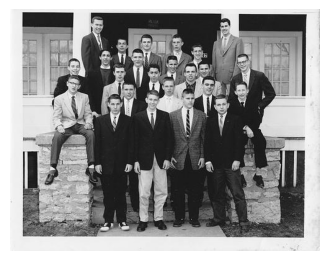

Generated Caption:

[CLS] a bunch of people are standing in front of a building. there are lots of people standing around the building. they all have on shirts and pants. [SEP]


In [32]:
import matplotlib.pyplot as plt

temp = test_df.sample(8).images.iloc[0]
plt.figure(figsize=(4, 4))
plt.imshow(Image.open(temp).convert("RGB"))
plt.axis('off')
plt.show()

# Generate and display the caption
print("Generated Caption:\n")
caption = tokenizer.decode(t.generate(image_processor(Image.open(temp).convert("RGB"), return_tensors="pt").pixel_values)[0])
print(caption)

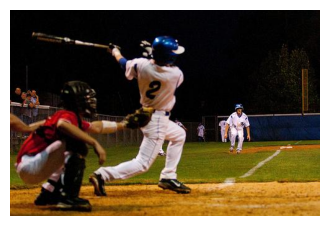

Generated Caption:

[CLS] [CLS] a man in a white shirt and black pants is standing on a baseball field. the man is holding a baseball bat. there is a baseball player standing behind him [SEP]


In [34]:
import matplotlib.pyplot as plt

temp = test_df.sample(28).images.iloc[0]
plt.figure(figsize=(4, 4))
plt.imshow(Image.open(temp).convert("RGB"))
plt.axis('off')
plt.show()

# Generate and display the caption
print("Generated Caption:\n")
caption = tokenizer.decode(t.generate(image_processor(Image.open(temp).convert("RGB"), return_tensors="pt").pixel_values)[0])
print(caption)

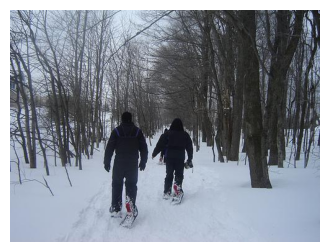

Generated Caption:

[CLS] [CLS] a man is standing on top of a snowboard. he is wearing a short sleeved shirt and black pants. the man is holding a white ski cap. the other [SEP]


In [43]:
import matplotlib.pyplot as plt

temp = test_df.sample(42).images.iloc[0]
plt.figure(figsize=(4, 4))
plt.imshow(Image.open(temp).convert("RGB"))
plt.axis('off')
plt.show()

# Generate and display the caption
print("Generated Caption:\n")
caption = tokenizer.decode(t.generate(image_processor(Image.open(temp).convert("RGB"), return_tensors="pt").pixel_values)[0])
print(caption)

In [44]:
# List to store generated captions
generated_captions = []

# Iterate through all images in the test dataset
for idx, row in test_df.iterrows():
    # Load and process the image
    image_path = row['images']
    image = Image.open(image_path).convert("RGB")
    pixel_values = image_processor(image, return_tensors="pt").pixel_values

    # Generate caption for the image
    caption = tokenizer.decode(t.generate(pixel_values)[0])

    # Store the generated caption
    generated_captions.append((image_path, caption))
    
    print(f"Image: {image_path}")
    print(f"Caption: {caption}\n")

Image: /kaggle/input/custom-captions/custom_captions_dataset/test/test_1.jpg
Caption: [CLS] there are people standing in front of a building. there is a large building behind the buildings. there are many people standing on the sidewalk. [SEP]

Image: /kaggle/input/custom-captions/custom_captions_dataset/test/test_2.jpg
Caption: [CLS] a person wearing a black jacket and black pants is standing on top of a snowboard. there is a person standing behind the person. there are trees behind the [SEP]

Image: /kaggle/input/custom-captions/custom_captions_dataset/test/test_3.jpg
Caption: [CLS] a bed is in the middle of a room. the bed is white in color. there is a picture hanging from the bed. there are two pillows in front of [SEP]

Image: /kaggle/input/custom-captions/custom_captions_dataset/test/test_4.jpg
Caption: [CLS] a train is coming down the tracks. the train is red in color. there are people standing on the train tracks. there is a large building behind the train. [SEP]

Image: /kaggl

In [45]:
# creating json files to store the captions in the format needed for using evaluation metrics

import json

gen_paths=[]
gen_caps=[]

for i in range(len(generated_captions)):
    gen_paths.append(generated_captions[i][0])
    gen_caps.append(generated_captions[i][1])

imags_json=[]
for idx,path in enumerate(gen_paths):
    imags_json.append({
        "license": 1,
        "url": path,
        "file_name": "COCO_val2014_000000572233.jpg",
        "id": idx,
        "width": 640,
        "date_captured": "2013-11-25 14:48:33",
        "height": 427
    }
    )

# Assuming actual_captions and generated_captions are lists of captions
actual_captions_json = []
for idx, caption in enumerate(actual_captions):
    actual_captions_json.append({
        "image_id": idx,  # Assuming image IDs start from 0 and are sequential
        "id": idx,  # Assuming IDs are unique and sequential
        "caption": caption
    })

generated_captions_json = []
for idx, caption in enumerate(gen_caps):
    generated_captions_json.append({
        "image_id": idx,  # Assuming image IDs start from 0 and are sequential
        "caption": caption
    })


# Create a new JSON object
data = {
    "info": {
        "description": "This is stable 1.0 version of the 2014 MS COCO dataset.",
        "url": "http://mscoco.org",
        "version": "1.0",
        "year": 2014,
        "contributor": "Microsoft COCO group",
        "date_created": "2015-01-27 09:11:52.357475"
    },
    "images": imags_json,
    "type": "captions",
    "licenses": [
        {
            "url": "http://creativecommons.org/licenses/by-nc-sa/2.0/",
            "id": 1,
            "name": "Attribution-NonCommercial-ShareAlike License"
        },
        {
            "url": "http://creativecommons.org/licenses/by-nc/2.0/",
            "id": 2,
            "name": "Attribution-NonCommercial License"
        },
        {
            "url": "http://creativecommons.org/licenses/by-nc-nd/2.0/",
            "id": 3,
            "name": "Attribution-NonCommercial-NoDerivs License"
        },
        {
            "url": "http://creativecommons.org/licenses/by/2.0/",
            "id": 4,
            "name": "Attribution License"
        },
        {
            "url": "http://creativecommons.org/licenses/by-sa/2.0/",
            "id": 5,
            "name": "Attribution-ShareAlike License"
        },
        {
            "url": "http://creativecommons.org/licenses/by-nd/2.0/",
            "id": 6,
            "name": "Attribution-NoDerivs License"
        },
        {
            "url": "http://flickr.com/commons/usage/",
            "id": 7,
            "name": "No known copyright restrictions"
        },
        {
            "url": "http://www.usa.gov/copyright.shtml",
            "id": 8,
            "name": "United States Government Work"
        }
    ],
    "annotations": actual_captions_json  # Use actual_captions_json or generated_captions_json here
}

data2 = generated_captions_json

# Save the JSON to a file
with open('captions.json', 'w') as f:
    json.dump(data, f, indent=4)
    
# Save the JSON to a file
with open('gen_captions.json', 'w') as ff:
    json.dump(data2, ff, indent=4)

### CIDEr

CIDEr (Consensus-based Image Description Evaluation) measures the consensus between the generated captions and the ground truth captions, emphasizing diversity and uniqueness.

### ROUGE - L

ROUGE-L (Recall-Oriented Understudy for Gisting Evaluation) focuses on the overlap of n-grams (words or sequences of words) between the generated and reference captions.

### SPICE

SPICE (Semantic Propositional Image Caption Evaluation) evaluates the semantic similarity between the generated captions and the ground truth captions, considering the meaning and structure of the sentences.

In [47]:
!pip install pycocotools

In [48]:
!pip install pycocoevalcap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 15.4 MB/s eta 0:00:0000:0100:01


In [49]:
from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice

class COCOEvalCap:
    def __init__(self, coco, cocoRes):
        self.evalImgs = []
        self.eval = {}
        self.imgToEval = {}
        self.coco = coco
        self.cocoRes = cocoRes
        self.params = {'image_id': coco.getImgIds()}

    def evaluate(self):
        imgIds = self.params['image_id']
        # imgIds = self.coco.getImgIds()
        gts = {}
        res = {}
        for imgId in imgIds:
            gts[imgId] = self.coco.imgToAnns[imgId]
            res[imgId] = self.cocoRes.imgToAnns[imgId]

        # =================================================
        # Set up scorers
        # =================================================
        print('tokenization...')
        tokenizer = PTBTokenizer()
        gts  = tokenizer.tokenize(gts)
        res = tokenizer.tokenize(res)

        # =================================================
        # Set up scorers
        # =================================================
        print('setting up scorers...')
        scorers = [
            (Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
            (Meteor(),"METEOR"),
            (Rouge(), "ROUGE_L"),
            (Cider(), "CIDEr"),
            (Spice(), "SPICE")
        ]

        # =================================================
        # Compute scores
        # =================================================
        for scorer, method in scorers:
            print ('computing %s score...'%(scorer.method()))
            score, scores = scorer.compute_score(gts, res)
            if type(method) == list:
                for sc, scs, m in zip(score, scores, method):
                    self.setEval(sc, m)
                    self.setImgToEvalImgs(scs, gts.keys(), m)
                    print("%s: %0.3f"%(m, sc))
            else:
                self.setEval(score, method)
                self.setImgToEvalImgs(scores, gts.keys(), method)
                print("%s: %0.3f"%(method, score))
        self.setEvalImgs()

    def setEval(self, score, method):
        self.eval[method] = score

    def setImgToEvalImgs(self, scores, imgIds, method):
        for imgId, score in zip(imgIds, scores):
            if not imgId in self.imgToEval:
                self.imgToEval[imgId] = {}
                self.imgToEval[imgId]["image_id"] = imgId
            self.imgToEval[imgId][method] = score

    def setEvalImgs(self):
        self.evalImgs = [eval for imgId, eval in self.imgToEval.items()]

### Note:
we have out json files for actual captions at: `/kaggle/working/captions.json`
and for generated captions at: `/kaggle/working/gen_captions.json`

please do changes to these paths if you are using anything different.

In [50]:
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap

annotation_file = '/kaggle/working/captions.json'
results_file = '/kaggle/working/gen_captions.json'

# create coco object and coco_result object
coco = COCO(annotation_file)
coco_result = coco.loadRes(results_file)

# create coco_eval object by taking coco and coco_result
coco_eval = COCOEvalCap(coco, coco_result)

# evaluate on a subset of images by setting
# coco_eval.params['image_id'] = coco_result.getImgIds()
# please remove this line when evaluating the full validation set
coco_eval.params['image_id'] = coco_result.getImgIds()

# evaluate results
# SPICE will take a few minutes the first time, but speeds up due to caching
coco_eval.evaluate()

# print output evaluation scores
for metric, score in coco_eval.eval.items():
    print(f'{metric}: {score:.3f}')

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 30956 tokens at 126922.89 tokens per second.
PTBTokenizer tokenized 36099 tokens at 155753.64 tokens per second.


setting up scorers...
Progress: 384.5M / 384.5M (100.0%)
Extracting stanford-corenlp-3.6.0 ...
Done.
computing Bleu score...
{'testlen': 32500, 'reflen': 27405, 'guess': [32500, 31572, 30644, 29716], 'correct': [10649, 3126, 984, 261]}
ratio: 1.185914979018384
Bleu_1: 0.328
Bleu_2: 0.180
Bleu_3: 0.101
Bleu_4: 0.055
computing METEOR score...
METEOR: 0.135
computing Rouge score...
ROUGE_L: 0.260
computing CIDEr score...
CIDEr: 0.263
computing SPICE score...


Parsing reference captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.7 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.4 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classif

SPICE evaluation took: 5.411 min
SPICE: 0.097
Bleu_1: 0.328
Bleu_2: 0.180
Bleu_3: 0.101
Bleu_4: 0.055
METEOR: 0.135
ROUGE_L: 0.260
CIDEr: 0.263
SPICE: 0.097


### Storing files and directories

A zip file named 'OUTPUT_NAME.zip' is created in the current working directory to store all the files and directories inside 'kaggle/working'.

In [51]:
import shutil
shutil.make_archive('OUTPUT_NAME', 'zip', 'kaggle/working')

'/kaggle/working/OUTPUT_NAME.zip'